In [204]:
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
from matplotlib.ticker import PercentFormatter

plt.rcParams.update(
    {
        "figure.constrained_layout.use": True,
        "axes.prop_cycle": cycler(
            color=["xkcd:kelly green", "xkcd:orange", "xkcd:bright blue"]
        ),
    }
)

In [205]:
from matplotlib.axes import Axes
from matplotlib.container import BarContainer

def add_bar_labels(ax: Axes, **kwargs):
    """Add labels to bars in all bar plots in the axes.
    Parameters
    ----------
    ax : Axes
        The axes to add labels to.
    kwargs
        Additional keyword arguments are passed to ax.bar_label.
    """
    for container in ax.containers:
        if isinstance(container, BarContainer):
            ax.bar_label(container, **kwargs)

In [206]:
from pathlib import Path
from pandas._typing import AstypeArg

DATASET_DIR = Path("./datasets")

IMR_TYPES = ["Medical Necessity", "Experimental"]
PRIORITIES = ["Standard", "Expedited"]
OUTCOMES = ["Insurer Denial Overturned", "Insurer Denial Upheld", "Insured Withdrew"]

dtypes: dict[str, AstypeArg] = {
    "reference_number": "string",
    "year": "Int64",
    "imr_type": pd.CategoricalDtype(IMR_TYPES, ordered=True),
    "priority": pd.CategoricalDtype(PRIORITIES, ordered=True),
    "diagnosis": "category",
    "diagnosis_subcategory": "category",
    "treatment": "category",
    "treatment_subcategory": "category",
    "outcome": pd.CategoricalDtype(OUTCOMES, ordered=True),
    "age": "Int64",
    "gender": "category",
    "statutory_criteria": "object",  # list[str]
    "primary_language": "category",
    "race": "object",  # list[str]
    "imro_review_period": "Int64",
    "determination_period": "Int64",
}

df: pd.DataFrame = pd.read_csv(
    DATASET_DIR / "./imr_report.csv",
    sep=",",
    header=0,
    names=[*dtypes],
    index_col="reference_number",
    converters={
        "primary_language": lambda x: (
            pd.NA
            if str.casefold(x)
            in {
                "-",
                "decline to state",
                "dts",
                "other",
                "prefer not to disclo",
                "unknown",
            }
            else x
        ),
    },
    na_values={
        **dict.fromkeys(["age", "gender", "statutory_criteria"], "-"),
        "diagnosis_subcategory": ["Unspecified", "unspecified", "Not Applicable"],
        "treatment": "Not Applicable",
        "race": ["-", "Decline to state"],
        "imro_review_period": " days",
    },
    encoding="cp1252",  # https://en.wikipedia.org/wiki/Windows-1252
).set_flags(allows_duplicate_labels=False)

df.index = df.index.str.strip()
df = df.assign(
    statutory_criteria=df.statutory_criteria.str.split("\\n").to_list(),
    race=df.race.str.split(", ").to_list(),
    imro_review_period=df.imro_review_period.str.extract(r"(\d+) days"),
    determination_period=df.determination_period.str.extract(r"(\d+) days"),
)

df = df.astype({k: v for k, v in dtypes.items() if k != df.index.name})

In [191]:
df.head()

,year,imr_type,priority,diagnosis,diagnosis_subcategory,treatment,treatment_subcategory,outcome,age,gender,statutory_criteria,primary_language,race,imro_review_period,determination_period
reference_number,,,,,,,,,,,,,,,
24-7980,2024,Medical Necessity,Expedited,Cancer,Prostate cancer,Cancer Treatment,High Intensity Focused Ultrasound,Insurer Denial Overturned,63,Male,[Peer-reviewed scientific and medical evidence...,NaN,NaN,3,9
24-7979,2024,Medical Necessity,Expedited,Circulatory/Heart,"Cardiovascular Disease, unspecified",Pharmacy/Prescription Drugs,Prescription Drugs,Insurer Denial Upheld,49,Female,[Peer-reviewed scientific and medical evidence...,English,[White],1,4
24-7978,2024,Medical Necessity,Standard,Endocrine/Metabolic,Growth Hormone Deficiency,Pharmacy/Prescription Drugs,Growth Hormone Therapy,Insurer Denial Overturned,9,Male,[Peer-reviewed scientific and medical evidence...,English,[White],11,16
24-7977,2024,Medical Necessity,Standard,Endocrine/Metabolic,Growth Hormone Deficiency,Injection / Infusion Therapy,Growth Hormone Therapy,Insurer Denial Upheld,10,Male,[Peer-reviewed scientific and medical evidence...,NaN,NaN,30,35
24-7976,2024,Medical Necessity,Expedited,Endocrine/Metabolic,Cushing's Syndrome,Pharmacy/Prescription Drugs,Prescription Drugs,Insurer Denial Upheld,57,Female,[Peer-reviewed scientific and medical evidence...,NaN,NaN,6,8


In [112]:
df.describe()

,year,age,imro_review_period,determination_period
count,4972.0,4970.0,2874.0,2997.0
mean,2016.337691,41.289336,18.083507,47.849516
std,3.623334,18.304638,10.286125,42.348706
min,2011.0,0.0,1.0,0.0
25%,2013.0,26.0,9.0,22.0
50%,2016.0,45.0,17.0,38.0
75%,2019.0,57.0,29.0,57.0
max,2024.0,96.0,50.0,746.0


Beforehand, cleaning some of the categorical data (`race`, `diagnosis`, `diagnosis_subcategory`, `treatment`, `treatment_subcategory`) is necessary due to some inconsistencies in the data, such as selecting both a race and `"Decline to state"` or variations in spelling.


In [207]:
# Remove "Decline to state" in tuples in race column
df.loc[df.race.notna(), "race"] = df.race.dropna().apply(
    lambda race: [r for r in race if r != "Decline to state"]
)

df = df.replace(
    {
        "diagnosis": {"Injuries": "Injuries / Poisoning"},
        "diagnosis_subcategory": {
            "Congenital Anomally": "Congenital Anomaly",
            "Sexual/Gender identity Issues": "Sexual/Gender Identity Issues",
            "Spondylolysis": "Spondylosis",
        },
        "treatment": {"Cardio Vascular": "Cardiovascular"},
        "treatment_subcategory": {
            "IOP-Intensive Outpatient Program": "IOP - Intensive Outpatient Program",
            "Transcranial Magnetic Stimulation": "TMS - Transcranial Magnetic Stimulation",
        },
    },
).assign(
    treatment_subcategory=df.treatment_subcategory.str.replace(
        r"schlerotherapy|scherotherapy", "sclerotherapy", regex=True
    )
)

/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_17812/359424232.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df = df.replace(


# Introduction


There are 4,972 datapoints in the dataset from years 2011 to 2024.

The dataset has 15 columns: year, imr_type, priority, diagnosis, diagnosis_subcategory, treatment, treatment_subcategory, outcome, age, gender, statutory_criteria, primary_language, race, imro_review_period, determination_period.

The 'outcome' column has 3 possible values: 'Insurer Denial Overturned', 'Insurer Denial Upheld' and 'Insured Withdrew'. 50.2% of cases end with outcome 'Insurer Denial Overturned', 49.0% end with 'Insurer Denial Upheld' and 0.9% end with 'Insured Withdrew'.


In [196]:
df.outcome.rename("Outcome").value_counts()

Outcome
Insurer Denial Overturned    2494
Insurer Denial Upheld        2435
Insured Withdrew               43
Name: count, dtype: int64

<Axes: title={'center': 'Outcome of IMR Requests'}>

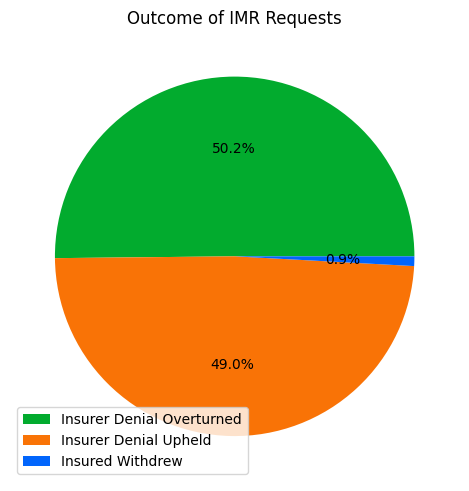

In [197]:
df.outcome.value_counts().plot(
    kind="pie",
    title="Outcome of IMR Requests",
    legend=True,
    ylabel="",
    autopct="{:.1f}%".format,
    labeldistance=None,
    normalize=True,
)

# Year


In general, you’ll notice a decreasing pattern in the number of cases reviewed in the IMR program, especially after 2020.


/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_17812/3974583096.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df.pivot_table(index="year", columns="outcome", aggfunc="size").rename_axis(


<Axes: title={'center': 'Number of IMR Cases by Year and Outcome'}, xlabel='Year', ylabel='Number of IMR Cases'>

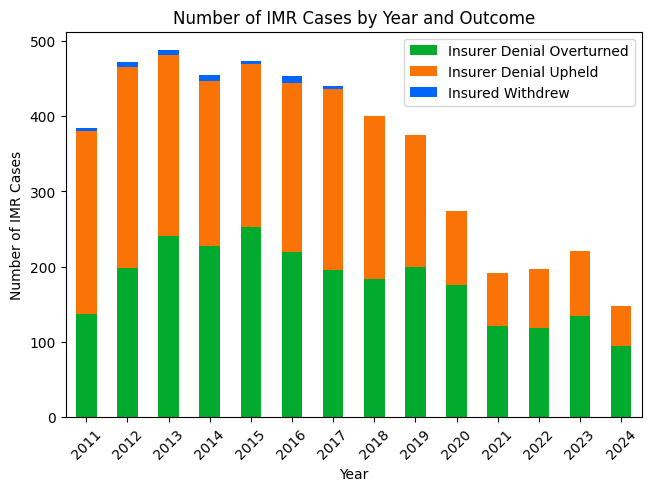

In [200]:
df.pivot_table(index="year", columns="outcome", aggfunc="size").rename_axis(
    None, axis=1
).plot.bar(
    title="Number of IMR Cases by Year and Outcome",
    xlabel="Year",
    ylabel="Number of IMR Cases",
    rot=45,
    stacked=True,
)

In [201]:
df.pivot_table(index="year", columns="outcome", aggfunc="size").assign(
    Total=lambda x: x.sum(axis=1)
)

/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_17812/2391074399.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df.pivot_table(index="year", columns="outcome", aggfunc="size").assign(


outcome,Insurer Denial Overturned,Insurer Denial Upheld,Insured Withdrew,Total
year,,,,
2011,137,243,4,384
2012,198,267,7,472
2013,240,241,7,488
2014,227,220,8,455
2015,252,217,4,473
2016,219,225,9,453
2017,196,240,4,440
2018,184,216,0,400
2019,199,176,0,375


On average, the IMR program reviewed 438 cases per year during 2011-2019 compared to an average of 221 cases per year in 2020-2023.


In [208]:
YEAR_RANGES = [[2011, 2019], [2020, 2023]]

pd.DataFrame(
    {
        "Year Range": [f"{l}-{r}" for [l, r] in YEAR_RANGES],
        "Average Number of Cases": [
            df.loc[df.year.between(l, r), "year"].value_counts().mean()
            for [l, r] in YEAR_RANGES
        ],
    }
)

,Year Range,Average Number of Cases
0,2011-2019,437.777778
1,2020-2023,221.000000


However, the percentage of insurer denials being overturned has also increased dramatically, from 36% in 2011 to 64% in 2024. Furthermore, there has been 0 cases with outcome 'Insured Withdrew' after 2018.


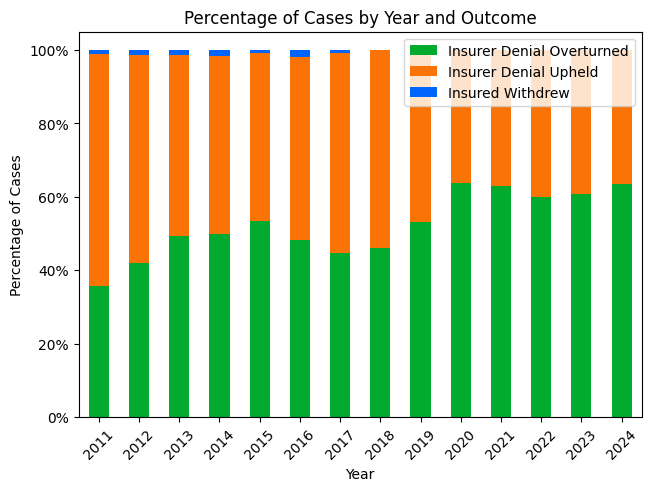

In [203]:
ax = (
    df.groupby("year")
    .value_counts(subset=["outcome"], normalize=True)
    .unstack()
    .rename_axis(None, axis=1)
    .plot.bar(
        title="Percentage of Cases by Year and Outcome",
        xlabel="Year",
        ylabel="Percentage of Cases",
        rot=45,
        stacked=True,
    )
)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

The average IMRO review period and determination period are 18 and 48 days, respectively.


In [164]:
df[["imro_review_period", "determination_period"]].describe()

,imro_review_period,determination_period
count,2874.0,2997.0
mean,18.083507,47.849516
std,10.286125,42.348706
min,1.0,0.0
25%,9.0,22.0
50%,17.0,38.0
75%,29.0,57.0
max,50.0,746.0


At first glance, it seems that both periods peaked in 2016 and started decreasing until 2020 (a pandemic year), where they started increasing again.


<Axes: title={'center': 'Average Determination Period and IMRO Review Period by Year'}, xlabel='Year', ylabel='Days'>

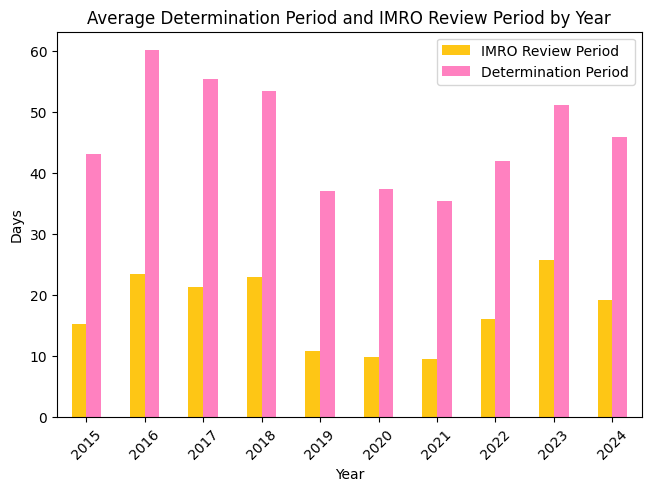

In [170]:
df.groupby("year")[
    ["imro_review_period", "determination_period"]
].mean().dropna().rename(
    columns={
        "imro_review_period": "IMRO Review Period",
        "determination_period": "Determination Period",
    }
).plot.bar(
    title="Average Determination Period and IMRO Review Period by Year",
    xlabel="Year",
    ylabel="Days",
    rot=45,
    color=["xkcd:golden yellow", "xkcd:pink"],
)

# IMR Type


An IMR case can either be of type "Medical Necessity" or "Experimental". Around 2/3 of the cases are of type "Medical Necessity" and 1/3 are of type "Experimental". Cases of type "Medical Necessity" have a higher percentage of insurer denials being overturned (52.5%) compared to cases of type "Experimental" (45.5%).


/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_17812/3391994241.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("imr_type").value_counts(


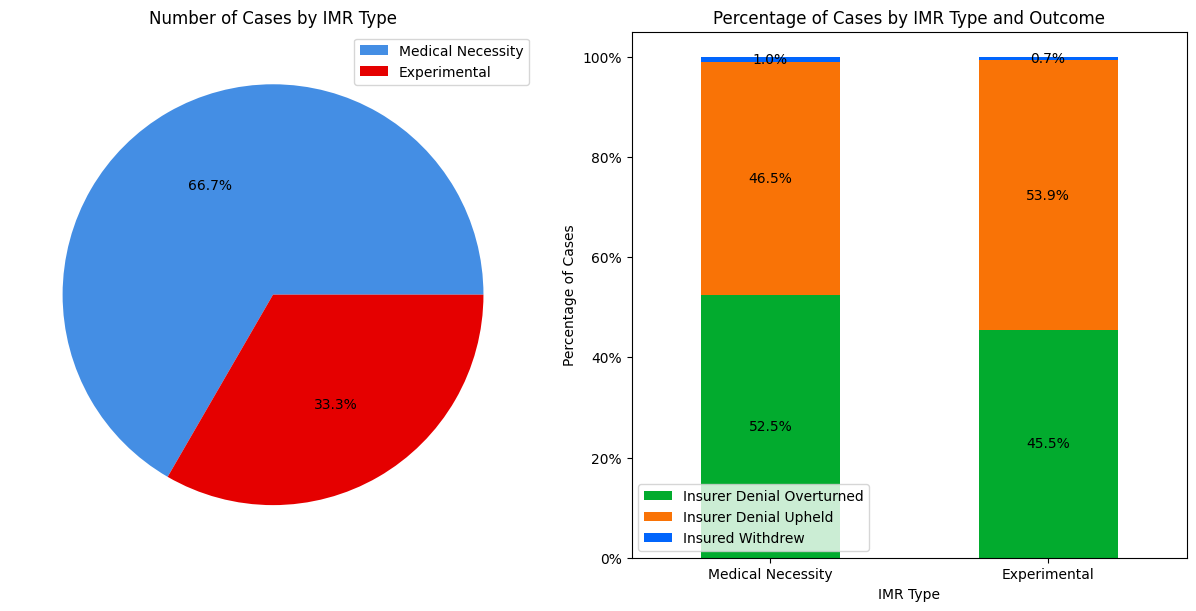

In [171]:
fig, axes = plt.subplot_mosaic([["left", "right"]], figsize=(12, 6))

df.imr_type.value_counts().plot(
    kind="pie",
    ax=axes["left"],
    title="Number of Cases by IMR Type",
    ylabel="",
    autopct="{:.1f}%".format,
    legend=True,
    labeldistance=None,
    colors=["xkcd:dark sky blue", "xkcd:red"],
)


df.groupby("imr_type").value_counts(
    subset=["outcome"], normalize=True
).unstack().rename_axis(None, axis=1).plot.bar(
    ax=axes["right"],
    title="Percentage of Cases by IMR Type and Outcome",
    xlabel="IMR Type",
    ylabel="Percentage of Cases",
    stacked=True,
    rot=0,
)
axes["right"].yaxis.set_major_formatter(PercentFormatter(1.0))
add_bar_labels(axes["right"], fmt="{:.1%}", label_type="center")

# Priority


The priority of an IMR case can be either "Standard" or "Expedited". Around 90% of the cases are of priority "Standard" and 10% are of priority "Expedited".


There is a slight edge for the "Expedited" cases in terms of the percentage of insurer denials being overturned (62.5% of "Expedited" vs 48.7% of "Standard" cases).


/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_17812/3636558374.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("priority")


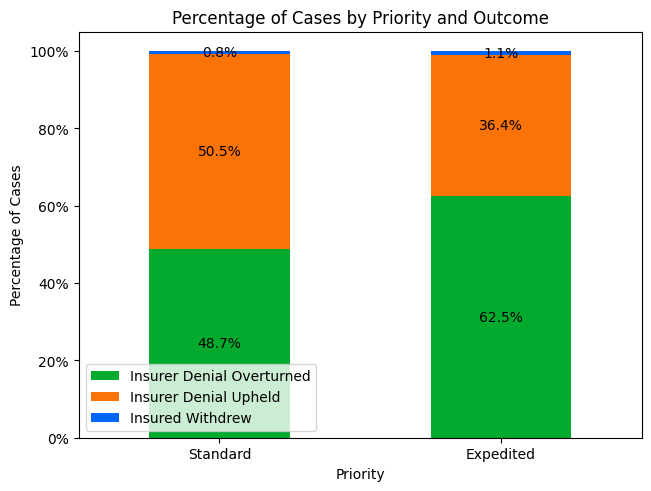

In [172]:
ax = (
    df.groupby("priority")
    .value_counts(subset=["outcome"], normalize=True)
    .unstack()
    .rename_axis(None, axis=1)
    .plot.bar(
        title="Percentage of Cases by Priority and Outcome",
        xlabel="Priority",
        ylabel="Percentage of Cases",
        stacked=True,
        rot=0,
    )
)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
add_bar_labels(ax, fmt="{:.1%}", label_type="center")

The median determination period for "Expedited" cases is 11 days, while for "Standard" cases it is 40 days. Also, the average IMRO review period for "Expedited" cases is 4 days, while for "Standard" cases it is 20 days.

There are some major outliers such as case 14-3515, which had priority of "Standard" and a determination period of 746 days.


Text(0.5, 1.0, 'IMRO Review Period')

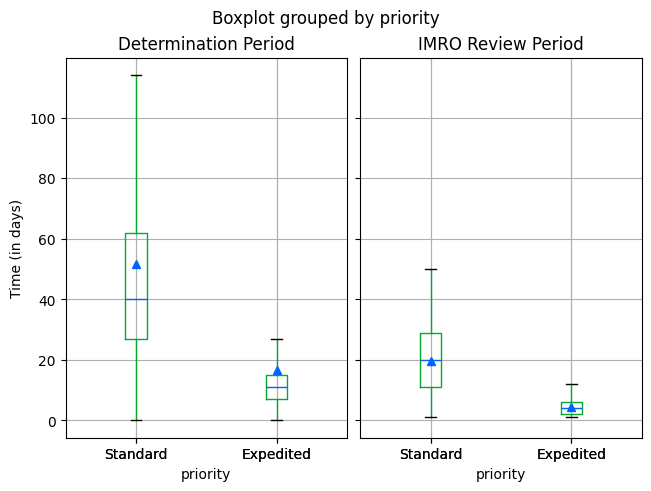

In [10]:
axes = df.boxplot(
    by="priority",
    column=["determination_period", "imro_review_period"],
    showfliers=False,
    showmeans=True,
)

axes[0].set_ylabel("Time (in days)")
axes[0].set_title("Determination Period")
axes[1].set_title("IMRO Review Period")

/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_9328/2771230090.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("outcome")[["imro_review_period", "determination_period"]]


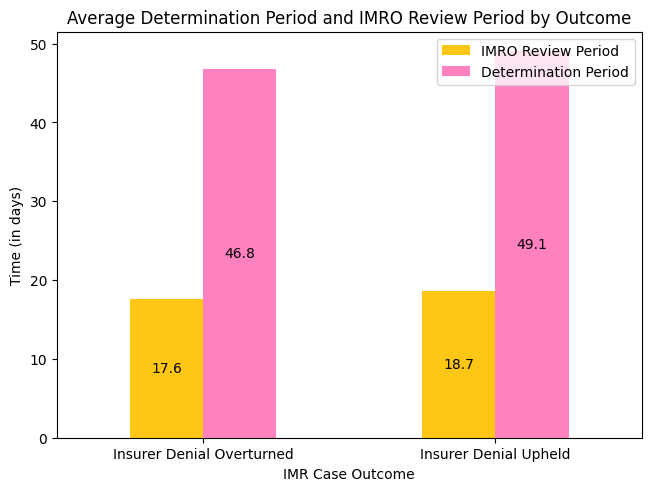

In [22]:
ax = (
    df.groupby("outcome")[["imro_review_period", "determination_period"]]
    .mean()
    .dropna()
    .rename(
        columns={
            "imro_review_period": "IMRO Review Period",
            "determination_period": "Determination Period",
        }
    )
    .plot.bar(
        title="Average Determination Period and IMRO Review Period by Outcome",
        xlabel="IMR Case Outcome",
        ylabel="Time (in days)",
        rot=0,
        color=["xkcd:golden yellow", "xkcd:pink"],
    )
)
add_bar_labels(ax, fmt="{:.1f}", label_type="center")

For someone with a primary language of English, the average IMRO review period is 17.7 days and the average determination period is 48.5 days. Conversely, for Spanish speakers, it is 22.5 days and 64.7 days, respectively. All other languages in aggregate average to 19.1 days and 61.9 days.

However, it is important to note that the cases involving English speakers vastly outnumber all other langauges, including Spanish: 1865 vs 15 vs 56. Hence, this trend may not be statistically significant.


In [ ]:
primary_language_grouped_df = (
    df.primary_language.dropna()
    .astype("object")
    .where(df.primary_language.isin(["English", "Spanish"]), "Other")
    .astype(pd.CategoricalDtype(["English", "Spanish", "Other"], ordered=True))
)

primary_language_grouped_df.value_counts()

primary_language
English    1865
Other        56
Spanish      15
Name: count, dtype: int64

/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_9328/649896285.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(primary_language_grouped_df)[


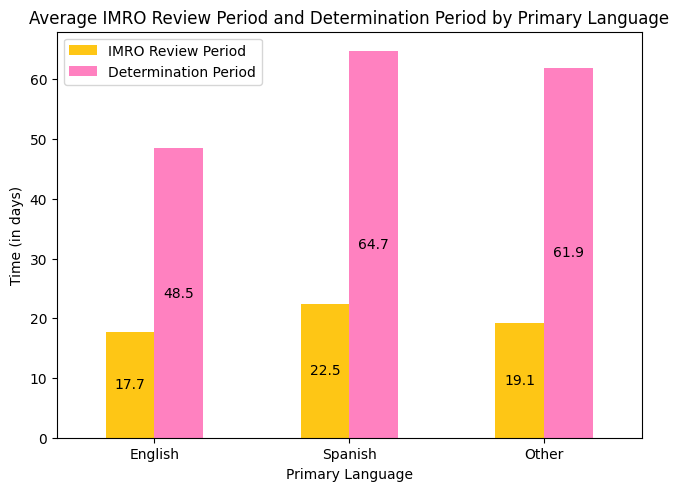

In [24]:
ax = (
    df.groupby(primary_language_grouped_df)[
        ["imro_review_period", "determination_period"]
    ]
    .mean()
    .rename(
        columns={
            "imro_review_period": "IMRO Review Period",
            "determination_period": "Determination Period",
        }
    )
    .plot.bar(
        title="Average IMRO Review Period and Determination Period by Primary Language",
        xlabel="Primary Language",
        ylabel="Time (in days)",
        rot=0,
        color=["xkcd:golden yellow", "xkcd:pink"],
    )
)
add_bar_labels(ax, fmt="{:.1f}", label_type="center")

# Diagnosis


The breakdown of the top 5 cases by diagnosis is as follows:

| Diagnosis                         | Count |
| --------------------------------- | ----- |
| Mental Disorders/Psychology       | 1152  |
| Musculoskeletal System/Connective | 865   |
| Cancer                            | 679   |
| Nervous System/Sense Organs       | 371   |
| Digestive System                  | 300   |

In other words, the top 5 diagnoses account for 3,367 cases, which is 67.7% or 2/3rds of the total number of cases (4972).


In [176]:
df.diagnosis.value_counts().rename_axis("Diagnosis")

Diagnosis
Mental Disorders/Psychology          1152
Musculoskeletal System/Connective     865
Cancer                                679
Nervous System/Sense Organs           371
Digestive System                      300
Circulatory/Heart                     268
Endocrine/Metabolic                   258
Genitourinary System                  156
Injuries / Poisoning                  151
Infectious Diseases                   146
Respiratory                           123
Preventative / Good Health            121
Ill-Defined Conditions                118
Skin                                   96
Pregnancy & Childbirth                 51
Congenital Abnormalities               44
Sexual/Gender Identity Issues          34
Blood/Hematology Disorders             29
Dental                                  6
Other                                   3
Perinatal Conditions                    1
Name: count, dtype: int64

Reviewing the data, by far the diagnosis with the most amount of insurer denials overturned 597 cases, followed is "Mental Disorders/Psychology" by "Musculoskeletal System/Connective" (368) and "Cancer" (314).

Percentage-wise, some notable (>100 cases) diagnoses in terms of their rate of insurer denials being overturned are Nervous System/Sense Organs (64.4%), Mental Disorders/Psychology (51.8%), and Endocrine/Metabolic (51.6%).


In [161]:
diagnosis_by_outcome = df.groupby(["diagnosis", "outcome"]).size().unstack().fillna(0)

print(
    "The top 10 diagnoses of cases with outcomes of 'Insurer Denial Overturned' are:\n"
)
print(
    diagnosis_by_outcome["Insurer Denial Overturned"]
    .sort_values(ascending=False)
    .head(10)
    .to_string(header=False)
)
print()

top_10_diagnoses = (
    (diagnosis_by_outcome["Insurer Denial Overturned"] / df.groupby("diagnosis").size())
    .sort_values(ascending=False)
    .head(10)
)

print(
    "The top 10 diagnoses likely to have an outcome of 'Insurer Denial Overturned' are:\n"
)
print(
    pd.DataFrame(
        {
            "Percentage": top_10_diagnoses,
            "Overturned Cases": diagnosis_by_outcome["Insurer Denial Overturned"].loc[
                top_10_diagnoses.index
            ],
            "Total": df.groupby("diagnosis").size().loc[top_10_diagnoses.index],
        }
    ).to_string(
        float_format="{:.1%}".format,
    )
)

The top 10 diagnoses of cases with outcomes of 'Insurer Denial Overturned' are:

Mental Disorders/Psychology          597
Musculoskeletal System/Connective    368
Cancer                               314
Nervous System/Sense Organs          239
Circulatory/Heart                    137
Endocrine/Metabolic                  133
Digestive System                     127
Infectious Diseases                   94
Genitourinary System                  77
Injuries / Poisoning                  69

The top 10 diagnoses likely to have an outcome of 'Insurer Denial Overturned' are:

                               Percentage  Overturned Cases  Total
diagnosis                                                         
Sexual/Gender Identity Issues       88.2%                30     34
Skin                                68.8%                66     96
Nervous System/Sense Organs         64.4%               239    371
Infectious Diseases                 64.4%                94    146
Congenital Abnormaliti

/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_67784/620108914.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  diagnosis_by_outcome = df.groupby(["diagnosis", "outcome"]).size().unstack().fillna(0)
/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_67784/620108914.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (diagnosis_by_outcome["Insurer Denial Overturned"] / df.groupby("diagnosis").size())
/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_67784/620108914.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version 

In [164]:
bottom_10_diagnoses = (
    (diagnosis_by_outcome["Insurer Denial Upheld"] / df.groupby("diagnosis").size())
    .sort_values(ascending=False)
    .head(10)
)

print(
    "The top 10 diagnoses most likely to have an outcome of 'Insurer Denial Upheld' are:\n"
)
print(
    pd.DataFrame(
        {
            "Percentage": bottom_10_diagnoses,
            "Overturned Cases": diagnosis_by_outcome["Insurer Denial Overturned"].loc[
                bottom_10_diagnoses.index
            ],
            "Total": df.groupby("diagnosis").size().loc[bottom_10_diagnoses.index],
        }
    ).to_string(
        float_format="{:.1%}".format,
    )
)

The top 10 diagnoses most likely to have an outcome of 'Insurer Denial Upheld' are:

                                   Percentage  Overturned Cases  Total
diagnosis                                                             
Perinatal Conditions                   100.0%                 0      1
Dental                                 100.0%                 0      6
Other                                   66.7%                 1      3
Digestive System                        57.3%               127    300
Musculoskeletal System/Connective       57.1%               368    865
Pregnancy & Childbirth                  54.9%                22     51
Injuries / Poisoning                    53.6%                69    151
Cancer                                  53.3%               314    679
Ill-Defined Conditions                  52.5%                56    118
Respiratory                             50.4%                59    123


/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_67784/2505936249.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (diagnosis_by_outcome["Insurer Denial Upheld"] / df.groupby("diagnosis").size())
/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_67784/2505936249.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  "Total": df.groupby("diagnosis").size().loc[bottom_10_diagnoses.index],


# Treatment


In [124]:
print(
    f"There are {df.treatment.nunique()} unique treatments. The 10 most common are:\n"
)
print(df.treatment.value_counts().head(10).to_string(header=False))

There are 39 unique treatments. The 10 most common are:

Diagnostic Imaging, Screening and Testing    1036
Pharmacy/Prescription Drugs                   573
Residential Treatment Center                  505
Injection / Infusion Therapy                  367
Mental Health Treatment                       275
Acute Medical Services - Inpatient            212
Cancer Treatment                              202
Durable Medical Equipment                     167
Neurosurgery                                  149
General Surgery                               139


In [125]:
subcategories_count_by_treatment = df.groupby(
    "treatment"
).treatment_subcategory.nunique()

print(f"The number of subcategories for each treatment are:\n")
print(
    subcategories_count_by_treatment.sort_values(ascending=False)
    .head(10)
    .to_string(header=False)
)
print()

print(
    f"Each treatment has an average of {subcategories_count_by_treatment.mean():.1f} subcategories."
)

The number of subcategories for each treatment are:

Diagnostic Imaging, Screening and Testing        64
Special Procedure                                50
General Surgery                                  50
Pharmacy/Prescription Drugs                      42
Durable Medical Equipment                        41
Acute Medical Services - Inpatient               35
Injection / Infusion Therapy                     35
Cancer Treatment                                 34
Electrical/ Thermal/ Radiofreq. Interventions    31
Mental Health Treatment                          29

Each treatment has an average of 20.3 subcategories.


/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_67784/2823547606.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subcategories_count_by_treatment = df.groupby(


In [ ]:
treatments_by_outcome = df.groupby(["treatment", "outcome"]).size().unstack().fillna(0)

bottom_10_treatments = (
    (treatments_by_outcome["Insurer Denial Upheld"] / df.groupby("treatment").size())
    .sort_values(ascending=False)
    .head(10)
)

print(
    "The top 10 treatments most likely to have an outcome of 'Insurer Denial Upheld' are:\n"
)
print(
    pd.DataFrame(
        {
            "Percentage": bottom_10_treatments,
            "Overturned Cases": treatments_by_outcome["Insurer Denial Upheld"].loc[
                bottom_10_treatments.index
            ],
            "Total": df.groupby("treatment").size().loc[bottom_10_treatments.index],
        }
    ).to_string(
        float_format="{:.1%}".format,
    )
)

The top 10 treatments most likely to have an outcome of 'Insurer Denial Upheld' are:

                                                                Percentage  Overturned Cases  Total
treatment                                                                                          
Chiropractic                                                         81.2%                26     32
Urology                                                              75.0%                 3      4
Neurosurgery                                                         72.5%               108    149
Dental/Orthodontic                                                   71.4%                10     14
Microsurgery                                                         71.4%                15     21
Medical/Oral appliance                                               66.7%                 8     12
Diagnostic/Physician Evaluation                                      66.7%                30     45
Ear, Nose and 

/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_67784/1980591667.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  treatments_by_outcome = df.groupby(["treatment", "outcome"]).size().unstack().fillna(0)
/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_67784/1980591667.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (treatments_by_outcome["Insurer Denial Upheld"] / df.groupby("treatment").size())
/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_67784/1980591667.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version 

# Age


The average age of patients is 45 years old, with a standard deviation of 18 years. The youngest patient is 0 years old and the oldest patient is 96 years old.


Text(0.5, 1.0, 'Distribution of Ages in IMR Cases')

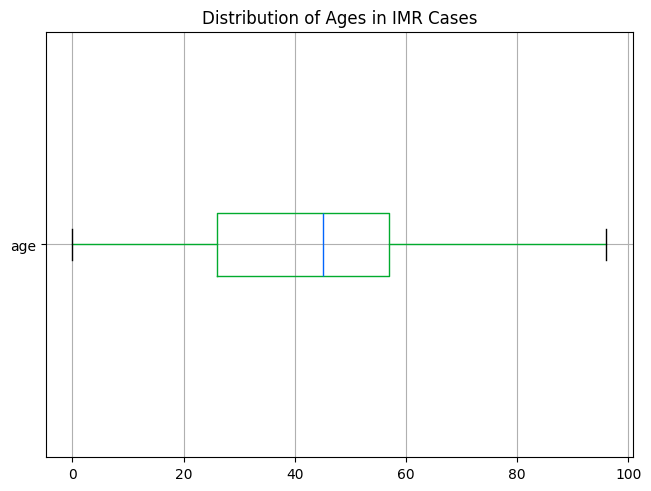

In [187]:
ax = df.boxplot(column="age", vert=False)
ax.set_title("Distribution of Ages in IMR Cases")

<Axes: title={'center': 'Distribution of Outcomes by Age'}, xlabel='Age (in years)', ylabel='Frequency'>

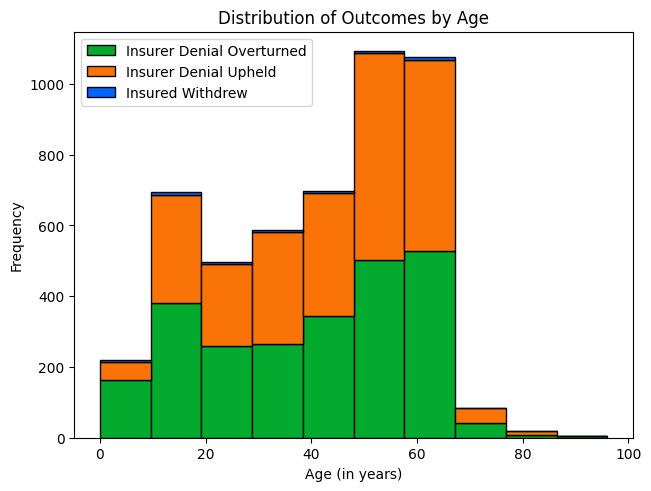

In [213]:
df.pivot(columns="outcome", values="age").rename_axis(None, axis=1).plot.hist(
    bins=10,
    title="Distribution of Outcomes by Age",
    xlabel="Age (in years)",
    stacked=True,
    edgecolor="black",
)

Alternatively, viewed in table form:

In [214]:
df.groupby([pd.cut(df.age, bins=10), "outcome"]).size().unstack()

/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_17812/3586042420.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([pd.cut(df.age, bins=10), "outcome"]).size().unstack()


outcome,Insurer Denial Overturned,Insurer Denial Upheld,Insured Withdrew
age,,,
"(-0.096, 9.6]",162,53,4
"(9.6, 19.2]",380,307,8
"(19.2, 28.8]",258,233,7
"(28.8, 38.4]",266,316,5
"(38.4, 48.0]",378,397,4
"(48.0, 57.6]",469,534,7
"(57.6, 67.2]",527,541,7
"(67.2, 76.8]",41,43,1
"(76.8, 86.4]",8,10,0


At first glance, it does appear that the rate of all outcomes is relatively equal (~50%) across all age groups older than 10. For ages 0-10 however, the rate of insurer denials being overturned seems much higher.

Rather than using bins based on the data, suppose we use bins based on age groups (0-10, 11-20, ...).

In [215]:
df.groupby(pd.cut(df.age, bins=range(0, 101, 10))).outcome.value_counts(
    normalize=True
).unstack()

/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_17812/835954955.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(df.age, bins=range(0, 101, 10))).outcome.value_counts(


outcome,Insurer Denial Overturned,Insurer Denial Upheld,Insured Withdrew
age,,,
"(0, 10]",0.723140,0.260331,0.016529
"(10, 20]",0.538881,0.450205,0.010914
"(20, 30]",0.506422,0.478899,0.014679
"(30, 40]",0.457851,0.535537,0.006612
"(40, 50]",0.486228,0.508982,0.004790
"(50, 60]",0.477912,0.514859,0.007229
"(60, 70]",0.474648,0.518310,0.007042
"(70, 80]",0.560976,0.414634,0.024390
"(80, 90]",0.500000,0.500000,0.000000


At least here, it seems that 72% of the outcomes of those in the (0, 10] age group are "Insurer Denial Overturned". This is much higher than the other age groups, which are all around 50%. The largest outliers would be (70, 80]	at 56.1% and (30,40] at 45.8%

Investigating the youth age further (0-26, where 26 is the age in California where a person no longer qualifies for dependent coverage), it appears up until age 14, the rate of insurer denials being overturned is strictly above 50%. While there are some outliers (15: 64.6%, 17: 57%, 24: 56.3%, 26: 59.0%), it does seem to generally approximate closer to the average at around 50%.

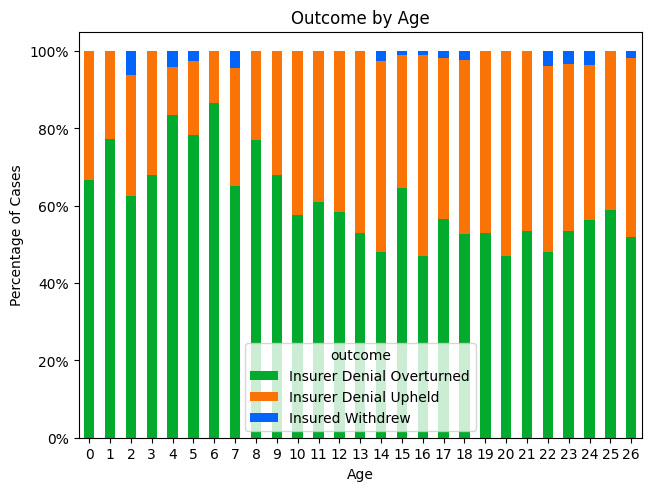

In [216]:
ax = (
    df[df.age <= 26]
    .groupby("age")
    .outcome.value_counts(normalize=True)
    .unstack()
    .plot.bar(
        title="Outcome by Age",
        xlabel="Age",
        ylabel="Percentage of Cases",
        stacked=True,
        rot=0,
    )
)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

It seems that 50.0% of cases in the "0-15" age group have diagnosis "Mental Disorders/Psychology", compared to only 20.0% in the "16-26" age group. As previously mentioned, the "Mental Disorders/Psychology" diagnosis has a high rate of insurer denials being overturned.

In [109]:
df.groupby([pd.cut(df.age, bins=[0, 15, 100])]).diagnosis.value_counts(normalize=True).unstack().T

/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_17812/1381236689.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([pd.cut(df.age, bins=[0, 15, 100])]).diagnosis.value_counts(normalize=True).unstack().T


age,"(0, 15]","(15, 100]"
diagnosis,,
Blood/Hematology Disorders,0.001855,0.006323
Cancer,0.012987,0.151536
Circulatory/Heart,0.003711,0.060072
Congenital Abnormalities,0.044527,0.004517
Dental,0.001855,0.001129
Digestive System,0.044527,0.062105
Endocrine/Metabolic,0.170686,0.037489
Genitourinary System,0.001855,0.035005
Ill-Defined Conditions,0.012987,0.025068


Furthermore, 19.2% of cases have the treatment "Autism Treatments" compared to 0.2% in the "16-26" age group, which was also mentioned to have a high rate of insurer denials being overturned even in the "Mental Disorders/Psychology" diagnosis.

In general, the "0-15" age group has more diagnoses with: Injection / Infusion Therapy (14.7%	vs 6.5%), Autism Treatments (19.2% vs 0.2%), and Residential Treatment Center	(13.4% vs 9.8%). 

Conversely, the "16-26" age group has more diagnoses with: Diagnostic Imaging, Screening and Testing (0.102421 vs 0.221820), Cancer Treatment (0.005587 vs. 0.045043), and Neurosurgery (0% vs 0.033726)

Correspondingly, the treatments most associated with the "0-15" age group have a higher rate of insurer denials being overturned: Injection / Infusion Therapy (72%), Autism Treatments (49%), and Residential Treatment Center (43%).

Conversely, the treatments most associated with the "16-100" age group have a lower rate of insurer denials being overturned: Diagnostic Imaging, Screening and Testing (46%), Cancer Treatment (43%), and Neurosurgery (26%).

# Statutory Criteria


In [54]:
df.statutory_criteria.explode().value_counts()

statutory_criteria
Peer-reviewed scientific and medical evidence regarding effectiveness of disputed service     2715
Nationally recognized professional standards                                                   639
Expert Opinion                                                                                  12
Generally accepted Standards of medical practice                                                 4
Treatments likely to provide a benefit when other treatments are not clincally efficacious       1
Name: count, dtype: int64

# Primary Language


In [88]:
df.primary_language.value_counts()

primary_language
English       1865
Mandarin        16
Korean          15
Spanish         15
Japanese         5
Russian          5
Vietnamese       5
Cantonese        3
Farsi            2
Punjabi          2
Arabic           1
Portuguese       1
Tagalog          1
Name: count, dtype: int64

# Gender


In [93]:
df.gender.value_counts()

gender
Female    2759
Male      2209
Name: count, dtype: int64

<Axes: title={'center': 'Gender Distribution'}>

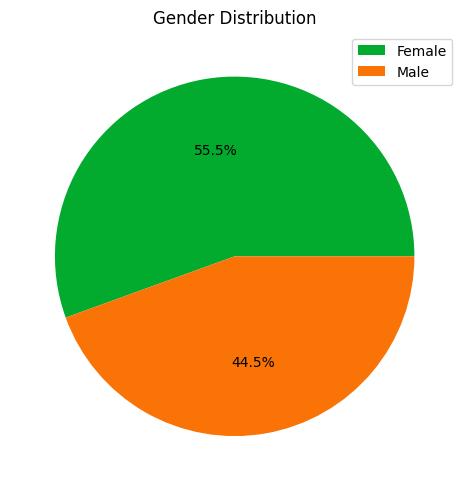

In [92]:
df.gender.value_counts().plot(
    kind="pie",
    title="Gender Distribution",
    ylabel="",
    autopct="{:.1f}%".format,
    legend=True,
    labeldistance=None,
)

/var/folders/ny/qfwz17s13_q8j69tt50n9w500000gn/T/ipykernel_17812/4013738838.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df.pivot_table(index="gender", columns="outcome", aggfunc="size")


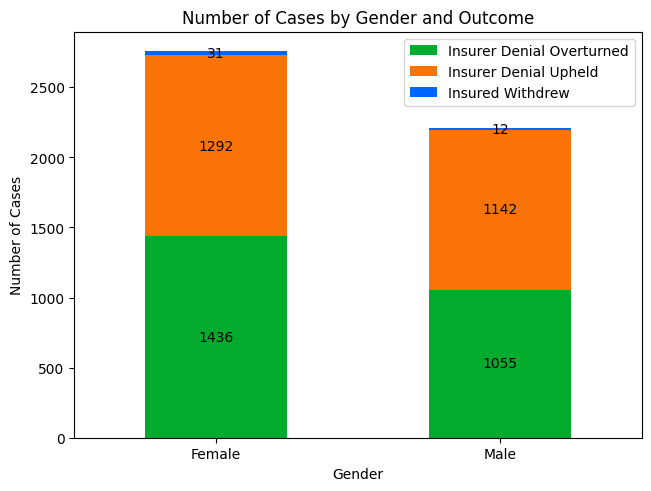

In [186]:
ax = (
    df.pivot_table(index="gender", columns="outcome", aggfunc="size")
    .rename_axis(None, axis=1)
    .plot.bar(
        title="Number of Cases by Gender and Outcome",
        xlabel="Gender",
        ylabel="Number of Cases",
        rot=0,
        stacked=True,
    )
)
add_bar_labels(ax, label_type="center")